1. The code snippet in Listing 1 shows the code to generate a noisy point set X amounting to a circle and the
code to estimate a circle—center and the radius—from a set of inliers in X.


In [2]:
import numpy as np
from scipy import optimize
from scipy import linalg
import matplotlib.pyplot as plt
import random
import cv2 as cv

In [3]:
def model_circle(point_list):
    """
    Returns the center and radius of the circle passing the given 3 points.
    """
    p1,p2,p3 = point_list[0], point_list[1], point_list[2]
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)

def get_inliers(data_list, center, r):
    """
    Returns the list of inliers to a model of a circle from a set of points.
    The threshold value is taken as 1/5th of the radius
    """
    inliers = []
    thresh = r//5

    for i in range(len(data_list)):
        error = np.sqrt((data_list[i][0]-center[0])**2 + (data_list[i][1]-center[1])**2) - r
        if error < thresh:
            inliers.append(data_list[i])

    return np.array(inliers)

def random_sample(data_list):
    """
    Returns a list of 3 random samples from a given list
    """
    sample_list = []
    random.seed(0)
    rand_nums = random.sample(range(1, len(data_list)), 3)
    for i in rand_nums:
        sample_list.append(data_list[i])
    return np.array(sample_list)

def calc_R(x_, y_, xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x_-xc)**2 + (y_-yc)**2)

def f_2(c, x_, y_):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(x_, y_, *c)
    return Ri - Ri.mean()

def estimateCircle(x_m, y_m, points):
    x_ = points[:,0]
    y_ = points[:,1]
    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate, (x_, y_))

    xc_2, yc_2 = center_2

    Ri_2 = calc_R(x_, y_, *center_2)
    R_2 = Ri_2.mean()
    # residu_2   = sum((Ri_2 - R_2)**2)
    return (xc_2, yc_2), R_2

In [4]:
# RANSAC_Circle
def RANSAC_Circle(data_list, itr):
    """
    Return the center, radius and the best sample and its inliers used to fit the circle to a set of points using RANSAC_Circle
    """
    best_sample = []
    best_center_sample = (0,0)
    best_radius_sample = 0
    best_inliers = []
    max_inliers = 0
    
    for i in range(itr):
        samples = random_sample(data_list)  # Generating a random sample of 3 points
        center, radius = model_circle(samples) # Calculting the center and the radius of the circle created by the 3 points
        inliers = get_inliers(data_list, center, radius) # Get the list of inliers
        num_inliers = len(inliers)

        # If a better approximation has been reached
        if num_inliers > max_inliers:
            best_sample = samples
            max_inliers = num_inliers
            best_center_sample = center
            best_radius_sample = radius
            best_inliers = inliers

    print("Center of Sample=", best_center_sample)
    print("Radius of Sample=", best_radius_sample)

    return best_center_sample, best_radius_sample, best_sample, best_inliers

Center of Sample= (0.3875662946664744, 0.20783294446043665)
Radius of Sample= 9.79406671357652
Ratio of inliers = 84.0 %
Center of RANSAC = (0.11145660376803412, 0.08177822844398985)
Radius of RANSAC = 9.895950353692601


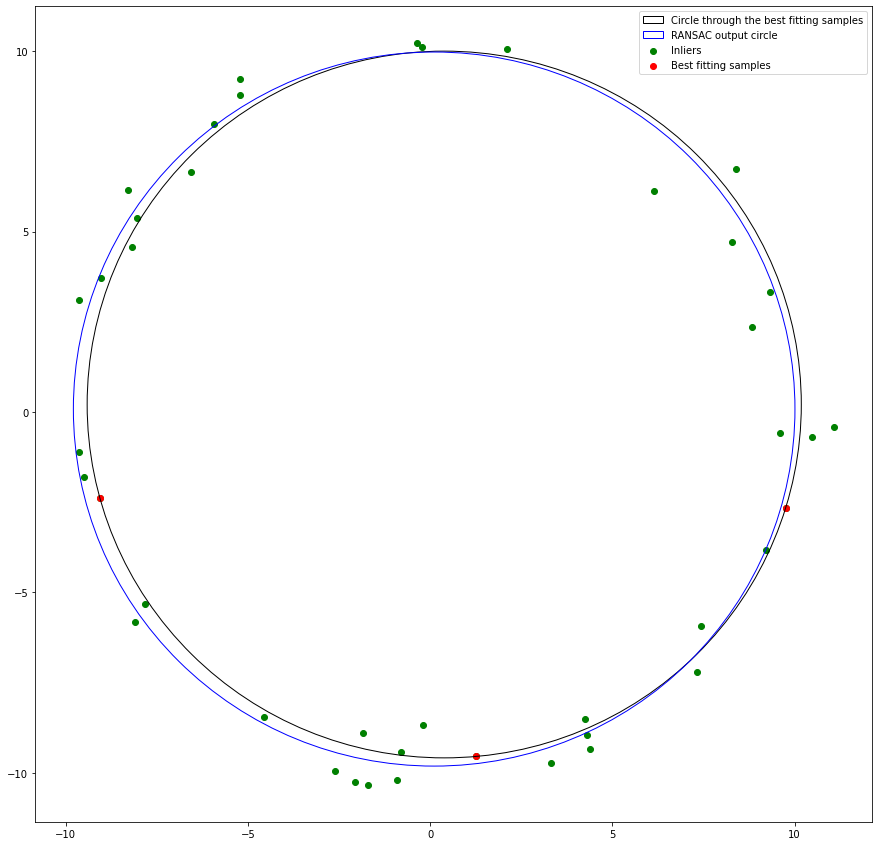

In [5]:
# Generating the set of points that estimate a circle randomly
np.random.seed(6)
N = 100
half_n = N // 2
r = 10
s = r / 16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x , y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Calculting the RANSAC outputs for the data set
center, radius, sample, inliers = RANSAC_Circle(X_circ, 20000)

# Plotting
fig,ax = plt.subplots(1,1, figsize = (15,15))
# Plotting the circle that is created by the best fitting points
circle = plt.Circle(center, radius, fill = False, label = "Circle through the best fitting samples", color = 'k')
ax.add_patch(circle)

# Plotting the inliers
print("Ratio of inliers =",len(inliers)/half_n*100, "%")
ax.scatter(inliers[:,0], inliers[:,1], color = 'green', label = "Inliers")

# Estimate the circle using the inliers using the least square method
ransac_center, ransac_radius = estimateCircle(center[0], center[1], inliers)
print("Center of RANSAC =", ransac_center)
print("Radius of RANSAC =", ransac_radius)
circle = plt.Circle(ransac_center, ransac_radius, fill = False, label = "RANSAC output circle", color = 'b')
ax.add_patch(circle)

# Plotting the circle
ax.scatter(sample[:,0], sample[:,1], color = 'red', label = "Best fitting samples")
ax.legend()

2. Figure 2 shows an architectural image1 with a flag 2
superimposed. This is done by clicking four points on a
planar surface in the architectural image, computing a homography that maps the flag image to this plane,
and warping the flag, and blending on to the architectural image. Carry this out for a couple of image pairs
of you own choice. You may explain the (non-technical) rationale of your choice

[[ 4.18900890e+00 -3.91737082e-01 -6.11765365e+02]
 [-1.21366168e-01  4.62577206e+00 -6.07786165e+02]
 [-3.59978557e-04  5.00321201e-04  1.00000000e+00]]


Text(0.5, 1.0, 'Image Warpped')

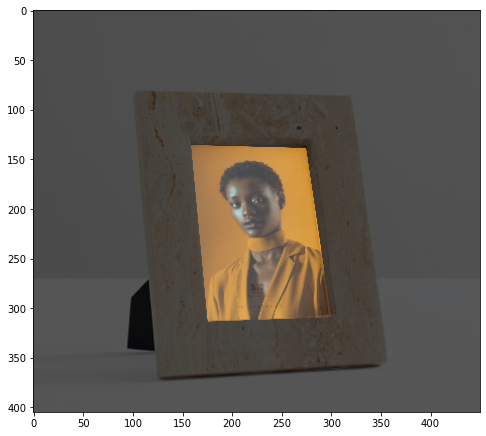

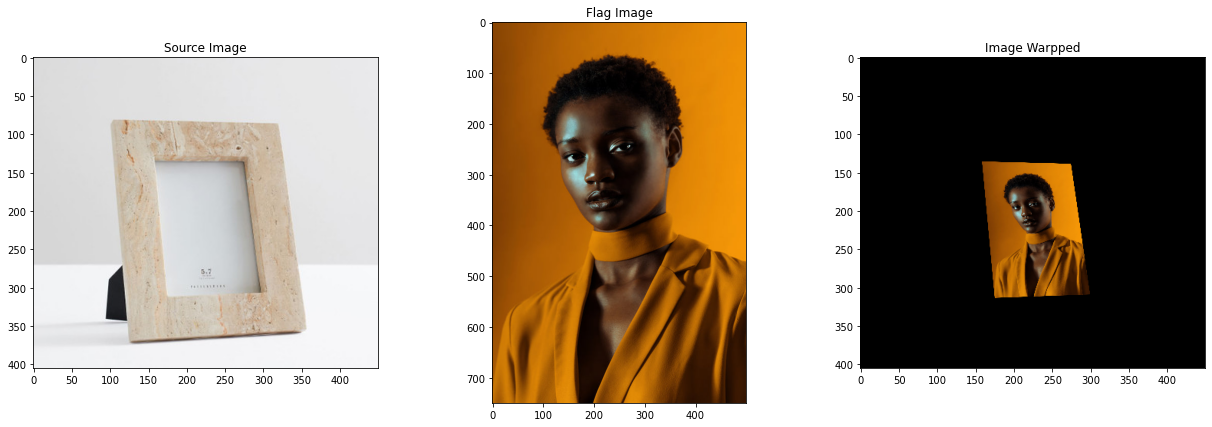

In [21]:
N = 4 # Number of points
global n
n = 0

# Parameters of the two images
p = np.empty((N,2))
p_flag = np.empty((N,2))

# Mouse callback function
def draw_circle(event,x,y,flags,param):
    global n
    p = param[0]
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(param[1],(x,y),5,(255,0,0),-1)
        p[n] = (x,y)
        n += 1

# Importing the images and creating copies
im = cv.imread('images/Frame1.jpg', cv.IMREAD_COLOR)
im_flag = cv.imread('images/portrait.jpg', cv.IMREAD_COLOR)
im_copy = im.copy()
im_flag_copy = im_flag.copy()

# im = cv.imread('images/Screen1.jpg', cv.IMREAD_COLOR)
# im_flag = cv.imread('images/DrStrange.jpg', cv.IMREAD_COLOR)
# im_copy = im.copy()
# im_flag_copy = im_flag.copy()

# im = cv.imread('images/005.jpg', cv.IMREAD_COLOR)
# im_flag = cv.imread('images/Flag_of_the_United_Kingdom.png', cv.IMREAD_COLOR)
# im_copy = im.copy()
# im_flag_copy = im_flag.copy()

# Getting the mouse points of the base image
cv.namedWindow('Image', cv.WINDOW_AUTOSIZE)
param = [p, im_copy]
cv.setMouseCallback('Image',draw_circle, param)
while(1):
    cv.imshow('Image', im_copy)
    if n == N:
        break
    if cv.waitKey(20) & 0xFF == 27:
        break

# Getting the mouse points of the flag
n = 0
cv.namedWindow('Image Flag', cv.WINDOW_AUTOSIZE)
param = [p_flag, im_flag_copy]
cv.setMouseCallback('Image Flag',draw_circle, param)
while(1):
    cv.imshow('Image Flag', im_flag_copy)
    if n == N:
        break
    if cv.waitKey(20) & 0xFF == 27:
        break
cv.destroyAllWindows()

h, status = cv.findHomography(p, p_flag) # Calculating homography between image and flag
print(h)

# Warping image of flag
warped_img = cv.warpPerspective(im_flag, np.linalg.inv(h), (im.shape[1],im.shape[0])) 

# Blending
alpha = 0.35
beta = 1-alpha

blended = cv.addWeighted(im, alpha, warped_img, beta, 0.0)
fig, ax = plt.subplots(1,1,figsize= (8,8))
ax.imshow(cv.cvtColor(blended,cv.COLOR_BGR2RGB))

# Plotting the results
fig,ax=plt.subplots(1,3,figsize=(21,7))
ax[0].imshow(cv.cvtColor(im,cv.COLOR_BGR2RGB))
ax[0].set_title("Source Image")
ax[1].imshow(cv.cvtColor(im_flag,cv.COLOR_BGR2RGB))
ax[1].set_title("Flag Image")
ax[2].imshow(cv.cvtColor(warped_img,cv.COLOR_BGR2RGB))
ax[2].set_title("Image Warpped")

3. In this questions, we will stitch the two Graffiti image3
img1.ppm onto img5.ppm.<br>
(a) Compute and match SIFT features between the two images.<br>
(b) Compute the homography using your own code within RANSAC and compare with the homography
given in the dataset.<br>
(c) Stitch img1.ppm onto img5.ppm<br>

In [86]:
# Import images
img1 = cv.imread('graf/img1.ppm')  
img2 = cv.imread('graf/img2.ppm')  
img3 = cv.imread('graf/img3.ppm')  
img4 = cv.imread('graf/img4.ppm')  
img5 = cv.imread('graf/img5.ppm')

In [130]:
def sift_match(im1, im2):

    GOOD_MATCH_PERCENT = 0.65

    # Detect sift features
    sift = cv.SIFT_create()
    keypoint_1, descriptors_1 = sift.detectAndCompute(im1,None)
    keypoint_2, descriptors_2 = sift.detectAndCompute(im2,None)

    # Match features.
    matcher = cv.BFMatcher()
    matches = matcher.knnMatch(descriptors_1, descriptors_2, k = 2) 

    # Filter good matches using ratio test in Lowe's paper
    good_matches = []

    for a,b in matches:
        if a.distance < GOOD_MATCH_PERCENT*b.distance:
            good_matches.append(a)

    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoint_1[match.queryIdx].pt
        points2[i, :] = keypoint_2[match.trainIdx].pt

    # Plot the matching
    fig, ax = plt.subplots(figsize = (15,15))
    ax.axis('off')
    matched_img = cv.drawMatches(im1, keypoint_1, im2, keypoint_2, good_matches, im2, flags = 2)
    plt.imshow(cv.cvtColor(matched_img,cv.COLOR_BGR2RGB))
    plt.show()

    result = np.concatenate((points1,points2), axis = 1)

    return result

In [108]:
def calculateHomography(correspondences):

    assemble_list = []
    for points in correspondences:
        p1 = np.matrix([points.item(0), points.item(1), 1])
        p2 = np.matrix([points.item(2), points.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        assemble_list.append(a1)
        assemble_list.append(a2)

    assemble_matrix = np.matrix(assemble_list)

    #svd composition
    u, s, v = np.linalg.svd(assemble_matrix)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize 
    h = (1/h.item(8)) * h
    return h

In [109]:
#Calculate the geometric distance between estimated points and original points
def distance(matched_points, h):

    point1 = np.transpose(np.matrix([matched_points[0].item(0), matched_points[0].item(1), 1]))
    point2 = np.transpose(np.matrix([matched_points[0].item(2), matched_points[0].item(3), 1]))
    
    #get the value of point2 by the calculated homography matrix
    estimated_point2 = np.dot(h, point1)
    estimated_point2 = (1/estimated_point2.item(2))*estimated_point2

    #Calculate the error between the actual and estimated point
    error = point2 - estimated_point2
    return np.linalg.norm(error)

In [134]:
def ransac(points):
    maxInliers = []
    final_H = None
    for i in range(10):

        random_points = random_sample(points)

        # Generate the homography 
        homography = calculateHomography(random_points)
        inliers = []

        # Find the inliers
        for i in range(len(points)):
            d = distance(points[i], homography)
            if d < 5:
                inliers.append(points[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            final_H = homography
    
    return final_H, maxInliers

In [111]:
def homography_reshape(homography):
    homography_ = np.array(homography)
    homography_ = homography_.reshape(3,3)
    homography_ = homography_/(homography_[-1][-1])
    return homography_

In [141]:
def plot_warped(im1, im2, h):
    width = im1.shape[1] + im2.shape[1]
    height = im1.shape[0] + im2.shape[0]
    result = cv.warpPerspective(im1, h, (width, height))
    result[0:im2.shape[0], 0:im2.shape[1]] = im2
    fig, ax = plt.subplots(1,1,figsize= (8,8))
    ax.imshow(cv.cvtColor(result,cv.COLOR_BGR2RGB))

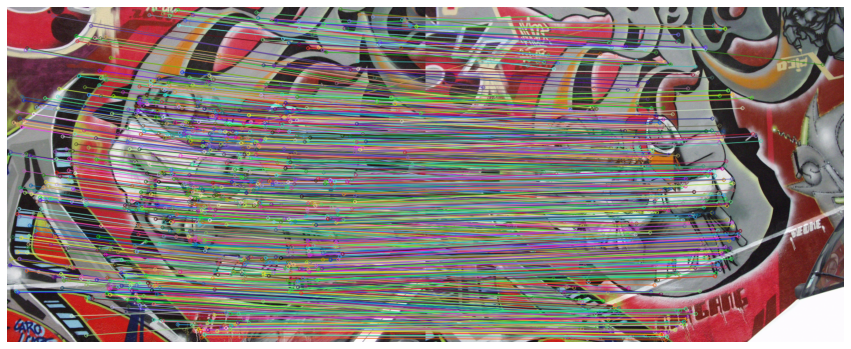

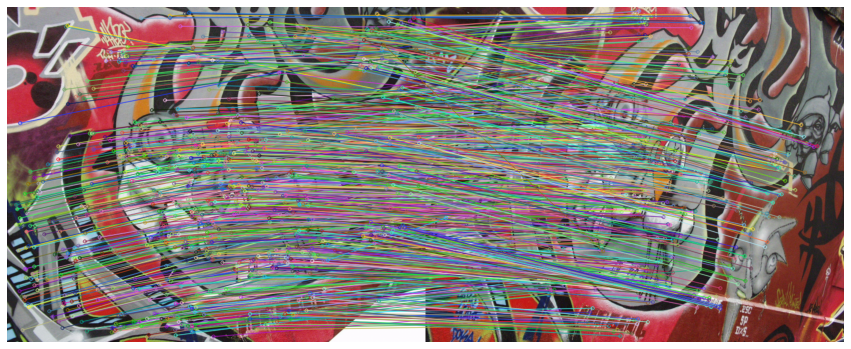

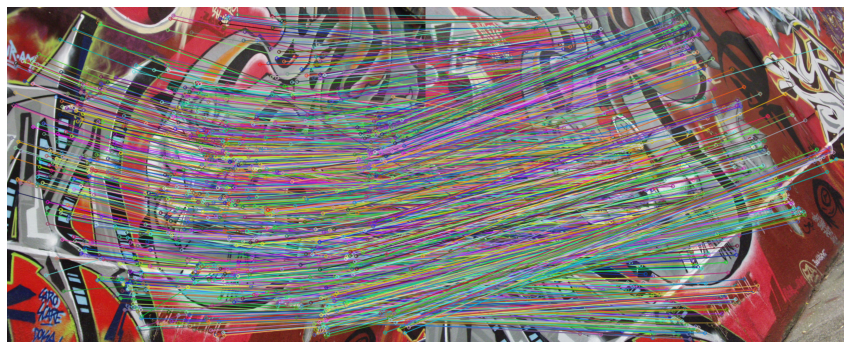

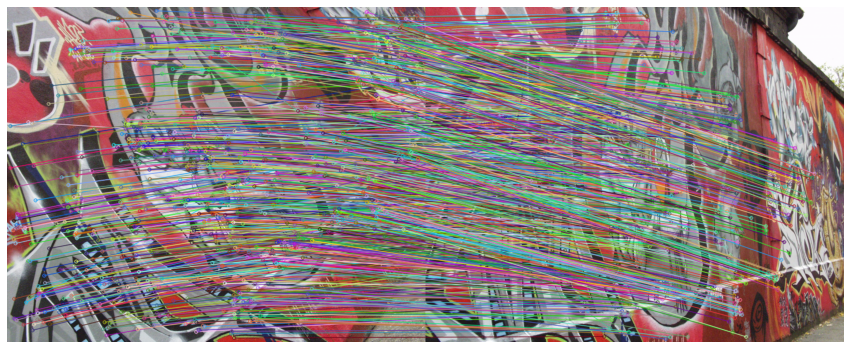

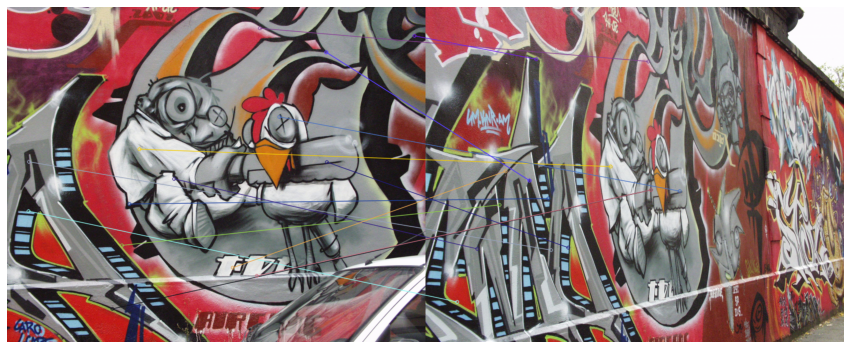

[[ 6.3542544e-01  5.6750124e-02  2.2101237e+02]
 [ 2.0147535e-01  1.1552247e+00 -2.5705213e+01]
 [ 4.7213545e-04 -3.5512424e-05  1.0000000e+00]]


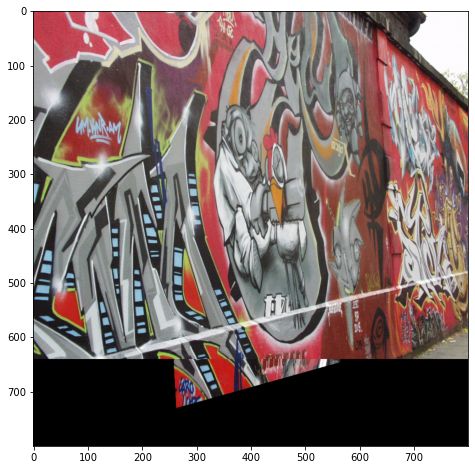

In [142]:
match1_2 = sift_match(img1,img2)
match2_3 = sift_match(img2,img3)
match3_4 = sift_match(img3,img4)
match4_5 = sift_match(img4,img5)
match1_5 = sift_match(img1,img5)

correspondenceMatrix1_2 = np.matrix(match1_2)
correspondenceMatrix2_3 = np.matrix(match2_3)
correspondenceMatrix3_4 = np.matrix(match3_4)
correspondenceMatrix4_5 = np.matrix(match4_5)

# Run ransac algorithm
H1_2, inliers1_2 = ransac(correspondenceMatrix1_2)
H2_3, inliers2_3 = ransac(correspondenceMatrix2_3)
H3_4, inliers3_4 = ransac(correspondenceMatrix3_4)
H4_5, inliers4_5 = ransac(correspondenceMatrix4_5)

H1_2 = homography_reshape(H1_2)
H2_3 = homography_reshape(H2_3)
H3_4 = homography_reshape(H3_4)
H4_5 = homography_reshape(H4_5)

H1_5 = H4_5@H3_4@H2_3@H1_2
H1_5 = homography_reshape(H1_5)
print(H1_5)

plot_warped(img1,img5,H1_5)